# Data Cleaning - Broadband V. Mobile, Coverage, and Mobile Phone Cost

In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patheffects
import numpy as np
import seaborn as sns
import plotly.express as px
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from selenium import webdriver
from scipy.stats import linregress
import numpy as np

## Data Importing and Cleaning

In [2]:
# Study data files
internet_data_csv = "../Resources/Internet_Inclusivity_Index_ Data_table.csv"

# Read the mouse data and the study results
internet_data = pd.read_csv(internet_data_csv)

# Display the data table for preview
internet_data.head()


,Country,Edition,1.1.1) Internet users,1.1.2) Fixed-line broadband subscribers,1.1.3) Mobile subscribers,1.1.4) Gender gap in internet access,1.1.5) Gender gap in mobile phone access,1.2.1) Average fixed broadband upload speed,1.2.2) Average fixed broadband download speed,1.2.3) Average fixed broadband latency,...,BG15) Internet users (population),BG16) Offline population,BG17) Internet access gender gap,BG18) Mobile phone access gender gap,BG19) Internet users (percent of population),BG20) Male internet users,BG21) Female internet users,BG22) Male mobile phone subscribers,BG23) Female mobile phone subscribers,BG24) Total fixed line broadband subscribers
0,Algeria,E1,31.9,5.71,108.8,NaN,NaN,1.69,3.39,74.00,...,15.23,24.64,NaN,NaN,38.2,NaN,NaN,95.5,89.9,2269348
1,Algeria,E2,47.3,7.05,116.0,22.0,7.8,6.12,7.85,76.92,...,17.44,23.18,13.0,7.0,42.9,59.0,46.0,90.0,83.0,2859567
2,Algeria,E3,54.2,7.76,110.8,11.7,8.9,2.59,3.77,64.71,...,19.71,21.62,7.0,8.0,47.7,60.0,53.0,90.0,82.0,3210267
3,Algeria,E4,74.4,7.26,111.7,21.7,7.3,1.97,3.87,64.99,...,20.64,21.45,13.0,6.0,49.0,60.0,47.0,82.0,76.0,3067022
4,Algeria,E5,74.4,8.32,109.4,10.9,8.0,1.41,3.84,54.09,...,20.64,21.45,7.0,7.0,49.0,64.0,57.0,87.0,80.0,3582739


In [3]:
# Update Edition to Year
edition_mapping = {'E1': 2017, 'E2': 2018, 'E3': 2019, 'E4': 2020, 'E5': 2021}

# Use the map function to replace values in the 'Edition' column
internet_data['Edition'] = internet_data['Edition'].map(edition_mapping)

# Rename the 'Edition' column to 'Year'
internet_data = internet_data.rename(columns={'Edition': 'Year'})

# We only want the last 3 years of data
# internet_data = internet_data[internet_data['Year'].isin([2019, 2020, 2021])]

# Drop columns we aren't looking to use for this analysis
# List columns to keep
columns_to_keep = ['Country', 'Year', 'BG2) Population', '1.1.1) Internet users', '1.1.2) Fixed-line broadband subscribers', '1.1.3) Mobile subscribers', '1.4.2) Rural electricity access']

# Update the dataframe to just use the columns to keep
internet_data = internet_data[columns_to_keep]

# Rename the columns to drop the numbers from the beginning
new_column_names = ['Country', 'Year', 'Population (millions)', 'Internet users (% of households)', 'Fixed-line broadband subscribers (per 100 inhabitants)', 'Mobile subscribers (per 100 inhabitants)', 'Rural electricity access (%)']
internet_data.columns = new_column_names

# Test Display
internet_data

,Country,Year,Population (millions),Internet users (% of households),Fixed-line broadband subscribers (per 100 inhabitants),Mobile subscribers (per 100 inhabitants),Rural electricity access (%)
0,Algeria,2017,40.6,31.9,5.71,108.8,96.70
1,Algeria,2018,41.3,47.3,7.05,116.0,96.87
2,Algeria,2019,42.1,54.2,7.76,110.8,96.87
3,Algeria,2020,42.9,74.4,7.26,111.7,100.00
4,Algeria,2021,43.7,74.4,8.32,109.4,96.70
...,...,...,...,...,...,...,...
595,Zimbabwe,2017,14.0,21.6,1.19,92.3,20.60
596,Zimbabwe,2018,14.2,22.1,1.22,91.8,11.00
597,Zimbabwe,2019,14.4,24.0,1.32,99.0,11.00
598,Zimbabwe,2020,14.6,30.3,1.41,89.4,11.50


In [12]:
data_to_load = Path("../Resources/mobile_data_index_breakdown.csv")

internet_adoption_data = pd.read_csv(data_to_load)

# Replace 'inf' with NaN and drop rows with NaN 
internet_data_clean = internet_adoption_data.replace([np.inf, -np.inf], np.nan).dropna()

#minor data cleaning - renaming columns
new_columns = {'1.1.1) Internet users': 'Internet Users', 
               '1.1.2) Fixed-line broadband subscribers': 'Broadband Subscribers',
               '1.1.3) Mobile subscribers': 'Mobile Subscribers',
               '1.3.1) Network coverage (min. 2G)': '2G Coverage',
               '1.3.2) Network coverage (min. 3G)': '3G Coverage',
               '1.3.3) Network coverage (min. 4G)': '4G Coverage',
               '2.1.2) Mobile phone cost (prepaid tariff)': 'Mobile Phone Cost (Prepaid)',
               '2.1.3) Mobile phone cost (postpaid tariff)': 'Mobile Phone Cose (Postpaid)',
               '2.1.4) Fixed-line monthly broadband cost': 'Broadband Cost',
               'BG2) Population': 'Population'
              }
internet_data_clean.rename(columns=new_columns, inplace=True)

internet_data_clean

,Country,Edition,Internet Users,Broadband Subscribers,Mobile Subscribers,2G Coverage,3G Coverage,4G Coverage,Mobile Phone Cost (Prepaid),Mobile Phone Cose (Postpaid),Broadband Cost,Population
0,Algeria,2017,31.9,5.71,108.8,99.19,46.00,0.00,5.501,4.914,3.82,40.6
1,Algeria,2018,47.3,7.05,116.0,98.00,83.36,3.62,5.501,2.007,4.01,41.3
2,Algeria,2019,54.2,7.76,110.8,98.00,90.00,30.49,2.038,2.207,4.41,42.1
3,Algeria,2020,74.4,7.26,111.7,98.04,97.45,52.84,1.981,2.207,4.41,42.9
4,Algeria,2021,74.4,8.32,109.4,98.04,97.72,53.63,2.379,2.207,4.41,43.7
...,...,...,...,...,...,...,...,...,...,...,...,...
595,Zimbabwe,2017,21.6,1.19,92.3,88.70,55.10,11.00,44.680,75.000,14.06,14.0
596,Zimbabwe,2018,22.1,1.22,91.8,88.90,55.25,22.64,32.970,32.558,13.95,14.2
597,Zimbabwe,2019,24.0,1.32,99.0,90.09,78.20,34.72,19.780,30.882,13.24,14.4
598,Zimbabwe,2020,30.3,1.41,89.4,93.00,84.00,35.00,10.056,30.882,13.24,14.6


In [13]:
country = internet_data_clean['Country'].unique()

In [14]:
#Calculate the total average of population for each country
population = internet_data_clean.groupby('Country')['Population'].mean()

### Broadband and Mobile Subscribers

In [15]:
# Calculate the total mean for each country for broadband
clean_broadband = internet_data_clean.groupby('Country')['Broadband Subscribers'].mean()

In [16]:
#Normalize the broadband subscribers per population
broadband_population = clean_broadband * population / 100

In [17]:
# Calculate the total mean for each country for mobile
clean_mobile = internet_data_clean.groupby('Country')['Mobile Subscribers'].mean()

In [18]:
#Normalize mobile subscribers per population
mobile_population = clean_mobile * population / 100

### 2g, 3g, 4g, Service

In [19]:
# Calculate the total average for each country for 2G
twog_data = internet_data_clean.groupby('Country')['2G Coverage'].mean()

In [20]:
# Calculate the total average for each country for 3G
threeg_data = internet_data_clean.groupby('Country')['3G Coverage'].mean()

In [21]:
# Calculate the total average for each country for 4G
fourg_data = internet_data_clean.groupby('Country')['4G Coverage'].mean()

### Broadband v. Mobile Cost

In [22]:
#Calculate broadband cost
broadband_cost = internet_data_clean.groupby('Country')['Broadband Cost'].mean()

In [23]:
#Calculate mobile phone cost - averaging prepaid and postpaid
prepaid = internet_data_clean.groupby('Country')['Mobile Phone Cost (Prepaid)'].mean()
postpaid = internet_data_clean.groupby('Country')['Mobile Phone Cose (Postpaid)'].mean()

mobile_cost = prepaid * postpaid / 2

## Data Summary

In [ ]:
# Combine each of the scores above into single DataFrame
internet_summary = pd.DataFrame(
    {
        "Country" : country,
        "Broadband Subscribers" : broadband_population,
        "Mobile Subscribers" : mobile_population,
        "2G Coverage" : twog_data,
        "3G Coverage" : threeg_data,
        "4G Coverage" : fourg_data,
        "Broadband Cost (% of GNI)" : broadband_cost,
        "Mobile Cost (% of GNI)" : mobile_cost
    }
)

# Minor data wrangling
internet_summary = internet_summary.reset_index(drop=True)

# Minor data cleaning
internet_summary["Broadband Subscribers"] = internet_summary["Broadband Subscribers"].map("{:,.2f}".format)
internet_summary["Mobile Subscribers"] = internet_summary["Mobile Subscribers"].map("{:,.2f}".format)
internet_summary["2G Coverage"] = internet_summary["2G Coverage"].map("{:,.2f}".format)
internet_summary["3G Coverage"] = internet_summary["3G Coverage"].map("{:,.2f}".format)
internet_summary["4G Coverage"] = internet_summary["4G Coverage"].map("{:,.2f}".format)
internet_summary["Broadband Cost (% of GNI)"] = internet_summary["Broadband Cost (% of GNI)"].map("{:,.2f}".format)
internet_summary["Mobile Cost (% of GNI)"] = internet_summary["Mobile Cost (% of GNI)"].map("{:,.2f}".format)

#export to CSV
internet_summary.to_csv("Resources/internet_subscriber_summary_.csv")

# Display the DataFrame
internet_summary

## Final Data Summary with Lat and Lon

In [ ]:
#Merge Internet Subscriber Summary with Latitude and Longitudes
#load the data
subscriber_data_to_load = Path("Resources/internet_subscriber_summary_.csv")
latlon_data_to_load = Path("../Resources/coordinates.csv")

#Read the data
subscriber_data = pd.read_csv(subscriber_data_to_load)
latlon_data = pd.read_csv(latlon_data_to_load)

#Merge the data on the Country dolumn
subscriber_data_complete = pd.merge(latlon_data, subscriber_data, how="left", on=["Country", "Country"])

#Rename two columns
new_columns = {'Latitude': 'Lat',
               'Longitude': 'Lng'}

subscriber_data_complete.rename(columns=new_columns, inplace=True)

#Drop an unnecessary column
unwanted_column = ['Unnamed: 0']
subscriber_data_complete.drop(columns=unwanted_column, inplace=True)

#Show
subscriber_data_complete

### Calculate Rates of Change

In [4]:
# Rate of change(%) = (new value - old value)/(old value) * 100

# Set up new dataframe
internet_adoption_rate = internet_data

# Add column for percentage change by country - broadband
internet_adoption_rate["Rate of Change (%) - Broadband"] = internet_data.groupby("Country")["Fixed-line broadband subscribers (per 100 inhabitants)"].pct_change().round(4) * 100

# Add column for percentage change by country - mobile
internet_adoption_rate["Rate of Change (%) - Mobile"] = internet_data.groupby("Country")["Mobile subscribers (per 100 inhabitants)"].pct_change().round(4) * 100

# Drop unnecessary rows and columns
internet_adoption_rate = internet_adoption_rate.loc[:, ['Country', 'Year', 'Population (millions)', 'Rate of Change (%) - Broadband', 'Rate of Change (%) - Mobile', 'Rural electricity access (%)']].dropna().reset_index(drop=True)

# Export CSV of cleaned data with new columns for team analysis
#csv_file_path = "../Resources/internet_adoption_rates_of_change.csv"
#internet_adoption_rate.to_csv(csv_file_path, index=False)
#print(f'DataFrame exported to {csv_file_path}')

# Replace 'inf' with NaN and drop rows with NaN
internet_adoption_rate_clean = internet_adoption_rate.replace([np.inf, -np.inf], np.nan).dropna()

# Test Display
internet_adoption_rate_clean

,Country,Year,Population (millions),Rate of Change (%) - Broadband,Rate of Change (%) - Mobile,Rural electricity access (%)
0,Algeria,2018,41.3,23.47,6.62,96.87
1,Algeria,2019,42.1,10.07,-4.48,96.87
2,Algeria,2020,42.9,-6.44,0.81,100.00
3,Algeria,2021,43.7,14.60,-2.06,96.70
4,Angola,2018,29.8,-47.27,-9.44,5.55
...,...,...,...,...,...,...
473,Zambia,2021,18.4,19.05,8.07,6.30
474,Zimbabwe,2018,14.2,2.52,-0.54,11.00
475,Zimbabwe,2019,14.4,8.20,7.84,11.00
476,Zimbabwe,2020,14.6,6.82,-9.70,11.50


### Chart Setup - Broadband

In [5]:
# Set up data from existing dataframe
df = internet_adoption_rate_clean

# Create a choropleth map for Broadband rate of change
fig_broadband = px.choropleth(
    df,
    locations='Country',
    locationmode='country names',
    color='Rate of Change (%) - Broadband',
    color_continuous_scale='RdYlGn',
    range_color=(-10, 10),
    animation_frame='Year',
    projection='natural earth',
    title='Rate of Change (%) - Broadband',
)

fig_broadband.update_geos(
    showocean=True,
    oceancolor='rgba(0,255,255,0.7)',
    showland=True,
    landcolor='rgba(212,212,212,0.7)',
    showcountries=True,
    showframe=False,
)

fig_broadband;

### Chart Setup - Mobile

In [6]:
# Set up data from existing dataframe
df = internet_adoption_rate_clean

# Create a choropleth map for Broadband rate of change
fig_mobile = px.choropleth(
    df,
    locations='Country',
    locationmode='country names',
    color='Rate of Change (%) - Mobile',
    color_continuous_scale='RdYlGn',
    range_color=(-5, 5),
    animation_frame='Year',
    projection='natural earth',
    title='Rate of Change (%) - Mobile',
)

fig_mobile.update_geos(
    showocean=True,
    oceancolor='rgba(0,255,255,0.7)',
    showland=True,
    landcolor='rgba(212,212,212,0.7)',
    showcountries=True,
    showframe=False,
)

fig_mobile;

### View Charts Congruently

In [7]:
fig_broadband.show()
fig_mobile.show()

### Chart comparison over Time

In [8]:
# Remove extreme outliers
internet_adoption_rate_condensed = internet_adoption_rate_clean[
    (internet_adoption_rate_clean['Rate of Change (%) - Broadband'] >= -50) &
    (internet_adoption_rate_clean['Rate of Change (%) - Broadband'] <= 50) &
    (internet_adoption_rate_clean['Rate of Change (%) - Mobile'] >= -50) &
    (internet_adoption_rate_clean['Rate of Change (%) - Mobile'] <= 50)
]

internet_adoption_rate_condensed

,Country,Year,Population (millions),Rate of Change (%) - Broadband,Rate of Change (%) - Mobile,Rural electricity access (%)
0,Algeria,2018,41.3,23.47,6.62,96.87
1,Algeria,2019,42.1,10.07,-4.48,96.87
2,Algeria,2020,42.9,-6.44,0.81,100.00
3,Algeria,2021,43.7,14.60,-2.06,96.70
4,Angola,2018,29.8,-47.27,-9.44,5.55
...,...,...,...,...,...,...
473,Zambia,2021,18.4,19.05,8.07,6.30
474,Zimbabwe,2018,14.2,2.52,-0.54,11.00
475,Zimbabwe,2019,14.4,8.20,7.84,11.00
476,Zimbabwe,2020,14.6,6.82,-9.70,11.50


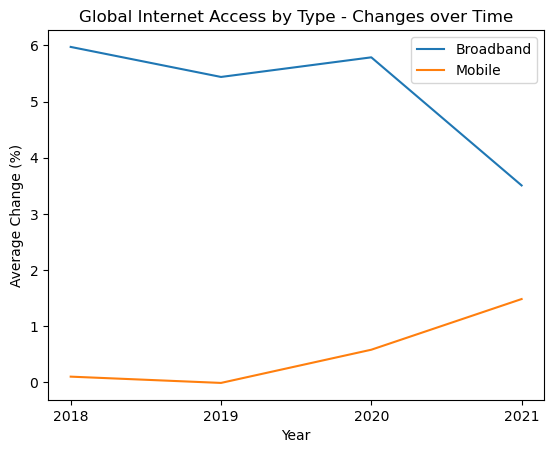

In [9]:
# List of years
years = internet_adoption_rate_condensed["Year"].unique()

# Find average rate of changes per year and rename the columns
yearly_avg_change_broadband = pd.DataFrame(internet_adoption_rate_condensed.groupby("Year")["Rate of Change (%) - Broadband"].mean()).reset_index()
yearly_avg_change_broadband = yearly_avg_change_broadband.rename(columns={"Rate of Change (%) - Broadband": "Average Rate of Change (%) - Broadband"})
yearly_avg_change_mobile = pd.DataFrame(internet_adoption_rate_condensed.groupby("Year")["Rate of Change (%) - Mobile"].mean()).reset_index()
yearly_avg_change_mobile = yearly_avg_change_mobile.rename(columns={"Rate of Change (%) - Mobile": "Average Rate of Change (%) - Mobile"})

# Merge the averages to form a new dataframe
merged_yearly_averages = yearly_avg_change_broadband.merge(yearly_avg_change_mobile, on="Year")

# Test Display
merged_yearly_averages

fig, ax = plt.subplots()
ax.plot(years,merged_yearly_averages["Average Rate of Change (%) - Broadband"], label="Broadband")
ax.plot(years,merged_yearly_averages["Average Rate of Change (%) - Mobile"], label="Mobile")
ax.set_xlabel("Year")
ax.set_ylabel("Average Change (%)")
ax.set_title("Global Internet Access by Type - Changes over Time")
ax.legend()
ax.set_xticks(years)
plt.show()

In [10]:
# Find average rate of changes per country and rename the columns
avg_change_broadband_all = pd.DataFrame(internet_adoption_rate_condensed.groupby("Country")["Rate of Change (%) - Broadband"].mean()).reset_index()
avg_change_broadband_all = avg_change_broadband_all.rename(columns={"Rate of Change (%) - Broadband": "Average Rate of Change (%) - Broadband"})
avg_change_mobile_all = pd.DataFrame(internet_adoption_rate_condensed.groupby("Country")["Rate of Change (%) - Mobile"].mean()).reset_index()
avg_change_mobile_all = avg_change_mobile_all.rename(columns={"Rate of Change (%) - Mobile": "Average Rate of Change (%) - Mobile"})

# Merge the averages to form a new dataframe
merged_averages = avg_change_broadband_all.merge(avg_change_mobile_all, on="Country")

# Test Display
merged_averages

,Country,Average Rate of Change (%) - Broadband,Average Rate of Change (%) - Mobile
0,Algeria,10.4250,0.222500
1,Angola,-5.4025,-1.447500
2,Argentina,5.4050,-3.205000
3,Australia,5.0500,0.677500
4,Austria,-0.1350,-5.970000
...,...,...,...
114,Uzbekistan,17.0000,12.770000
115,Venezuela,1.0625,-15.555000
116,Vietnam,16.8175,2.417500
117,Zambia,18.7500,5.823333


The r-value is: 0.03303467204224181


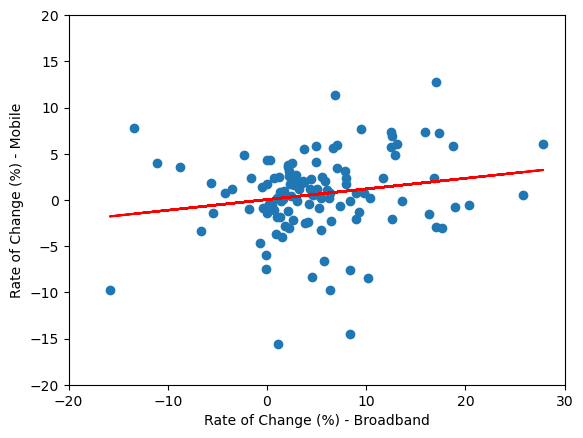

In [11]:
# Calculate the average change per year of both mobile and broadband access

# Find average rate of change for Broadband per country
avg_change_broadband = merged_averages["Average Rate of Change (%) - Broadband"]
avg_change_mobile = merged_averages["Average Rate of Change (%) - Mobile"]

# Define linear regression formula
def linear_regression_line(arg1, arg2):
    slope, intercept, r_value, p_value, std_err = linregress(arg1, arg2)
    line = slope * arg1 + intercept
    equation_text = f"y = {round(slope,2)}x {'+' if intercept >= 0 else '-'} {abs(round(intercept,2))}"
    return line, r_value, round(slope,2), round(intercept,2), equation_text

# Calculate Linear regression line
regression_line, r_value, slope, intercept, equation_text = linear_regression_line(avg_change_broadband, avg_change_mobile)

# Print the R^2 value
print(f"The r-value is: {r_value**2}")

#Create Plots
fig, ax = plt.subplots()
ax.scatter(avg_change_broadband, avg_change_mobile)
plt.plot(avg_change_broadband, regression_line, color='red')
ax.set_xlabel("Rate of Change (%) - Broadband")
ax.set_ylabel("Rate of Change (%) - Mobile")
ax.set_xlim(-20, 30)
ax.set_ylim(-20, 20)
plt.show()

## Broadband Top 10 Countries

In [ ]:
#Find the top 10 Broadband Countries
broadband_top_ten = broadband_population.nlargest(10)

In [ ]:
#Find the last 10 Broadband Countries
broadband_last_ten = broadband_population.nsmallest(10)

In [ ]:
#Find the Lat and Lon
#Set the Id's for the search
g_ids = ['China', 'United States', 'Japan', 'Germany', 'Russia', 'Brazil', 'France', 'United Kingdom', 
         'South Korea', 'India','Guinea', 'Congo (DRC)', 'Burundi', 'Liberia', 'Malawi', 'Burkina Faso', 'Niger', 
         'Rwanda', 'Papua New Guinea', 'Gabon']

#Search the DataFrame and return the results from the appended list
broadband_top_country = subscriber_data_complete[subscriber_data_complete['Country'].isin(g_ids)][['Country','Lat', 'Lng']]

#Set the new order of the DataFrame
order = ['China', 'United States', 'Japan', 'Germany', 'Russia', 'Brazil', 'France', 'United Kingdom', 
         'South Korea', 'India','Guinea', 'Congo (DRC)', 'Burundi', 'Liberia', 'Malawi', 'Burkina Faso', 'Niger', 
         'Rwanda', 'Papua New Guinea', 'Gabon']
lat_broadband = broadband_top_country.set_index('Country').reindex(order).reset_index()
lat_broadband

In [ ]:
#Add Data to two data frames
broadband_top = pd.DataFrame({"Broadband Top 10" : broadband_top_ten})
broadband_bottom = pd.DataFrame({"Broadband Bottom 10" : broadband_last_ten})

# Minor data cleaning - renaming
broadband_top = broadband_top.rename_axis('Top Country')
broadband_bottom = broadband_bottom.rename_axis('Bottom Country')

# Minor data cleaning - adding columns and values
broadband_top["Broadband Top 10"] = broadband_top["Broadband Top 10"].map("{:,.2f}".format)
broadband_top['Place'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
broadband_top['Number'] = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
broadband_bottom["Broadband Bottom 10"] = broadband_bottom["Broadband Bottom 10"].map("{:,.2f}".format)
broadband_bottom['Place'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
broadband_bottom['Number'] = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

# Display the DataFrame
display(broadband_top, broadband_bottom)

#Export both singles to one CSV
broadband_top.to_csv("Resources/Broadband_10.csv")
broadband_bottom.to_csv("Resources/Broadband_10.csv", mode='a', header=True)
lat_broadband.to_csv("Resources/Broadband_10.csv", mode='a', header=True)

In [2]:
#Import the complete CSV
data_to_load = Path("Resources/Broadband_10.csv")

broadband_ten_data = pd.read_csv(data_to_load)

#Split into two 
broadband_ten_data = broadband_ten_data.iloc[:, :6]

broadband_ten_data.rename(columns={'Top Country': 'Top Broadband Country'}, inplace=True)

#Show
broadband_ten_data


,Top Broadband Country,Broadband Top 10,Place,Number,Lat,Lng
0,China,360.17,1,10,35.000074,104.999927
1,United States,108.89,2,9,39.783730,-100.445882
2,Japan,40.56,3,8,36.574844,139.239418
3,Germany,33.04,4,7,51.163818,10.447831
4,Russia,30.75,5,6,64.686314,97.745306
5,Brazil,29.15,6,5,-10.333333,-53.200000
6,France,28.44,7,4,46.603354,1.888334
7,United Kingdom,26.02,8,3,54.702354,-3.276575
8,South Korea,21.03,9,2,36.638392,127.696119
9,India,18.31,10,1,22.351115,78.667743


In [41]:
%%capture --no-display
#Hover Cols
hover = ['Top Broadband Country', 'Broadband Top 10', 'Place']

# Configure the map plot
broadband_1 = broadband_ten_data.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "EsriTerrain",
    frame_width = 500,
    frame_height = 300,
    size = "Broadband Top 10",
    scale = 1.5,
    color = "Broadband Top 10",
    cmap='RdYlGn_r',
    title='Broadband Top 10 Countries by Penetration (%)',
    hover_cols = hover
)

# Display the map
broadband_1


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (Broadband Top 10,Top Broadband Country,Place)

<Figure size 640x480 with 0 Axes>

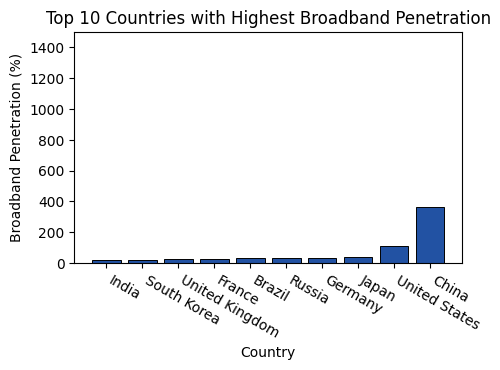

In [26]:
%matplotlib inline
plt.figure(figsize=(5, 3))
broadband_bar = broadband_ten_data.sort_values(by='Broadband Top 10', ascending=True)
ax = plt.bar(broadband_bar['Top Broadband Country'], broadband_bar['Broadband Top 10'], 
             color='#2252a3', alpha=1, linewidth=0.7, edgecolor="black")

# Add labels and title
plt.xlabel('Country')
plt.ylim(0, 1500)
plt.xticks(rotation=330, ha='left')
plt.ylabel('Broadband Penetration (%)')
plt.title('Top 10 Countries with Highest Broadband Penetration')

plt.savefig("Images/broadband10.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

## Mobile Top 10 Countries

In [ ]:
#Find the top 10 Mobile Countries
mobile_top_ten = mobile_population.nlargest(10)

In [ ]:
#Find the last 10 Mobile Countries
mobile_last_ten = mobile_population.nsmallest(10)

In [ ]:
#Find the Lat and Lon
#Set the Id's for the search
g_ids = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 
         'Bangladesh', 'Pakistan','Estonia', 'Trinidad & Tobago', 'Latvia', 'Bahrain', 'Namibia', 'Jamaica', 'Gabon', 
         'Liberia', 'Botswana', 'Mongolia']

#Search the DataFrame and return the results from the appended list
mobile_top_country = subscriber_data_complete[subscriber_data_complete['Country'].isin(g_ids)][['Country','Lat', 'Lng']]

#Set the new order of the DataFrame
order = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 
         'Bangladesh', 'Pakistan','Estonia', 'Trinidad & Tobago', 'Latvia', 'Bahrain', 'Namibia', 'Jamaica', 'Gabon', 
         'Liberia', 'Botswana', 'Mongolia']
lat_mobile = mobile_top_country.set_index('Country').reindex(order).reset_index()

In [ ]:
#Add Data to two data frames
mobile_top = pd.DataFrame({"Mobile Top 10" : mobile_top_ten})
mobile_bottom = pd.DataFrame({"Mobile Bottom 10" : mobile_last_ten})

# Minor data cleaning - renaming
mobile_top = mobile_top.rename_axis('Top Country')
mobile_bottom = mobile_bottom.rename_axis('Bottom Country')

# Minor data cleaning - adding columns and values
mobile_top["Mobile Top 10"] = mobile_top["Mobile Top 10"].map("{:,.2f}".format)
mobile_top['Place'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mobile_top['Number'] = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
mobile_bottom["Mobile Bottom 10"] = mobile_bottom["Mobile Bottom 10"].map("{:,.2f}".format)
mobile_bottom['Place'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mobile_bottom['Number'] = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

# Display the DataFrame
display(mobile_top, mobile_bottom)

#Export both singles to one CSV
mobile_top.to_csv("Resources/Mobile_10.csv")
mobile_bottom.to_csv("Resources/Mobile_10.csv", mode='a', header=True)
lat_mobile.to_csv("Resources/Mobile_10.csv", mode='a', header=True)

In [9]:
#Import the complete CSV
data_to_load = Path("Resources/Mobile_10.csv")

mobile_ten_data = pd.read_csv(data_to_load)

#Split into two 
mobile_ten_data = mobile_ten_data.replace({',': ''}, regex=True)
mobile_ten_data = mobile_ten_data.iloc[:, :6]

mobile_ten_data['Mobile Top 10'] = mobile_ten_data['Mobile Top 10'].astype(float)

mobile_ten_data.rename(columns={'Top Country': 'Top Mobile Country'}, inplace=True)

#Show
mobile_ten_data


,Top Mobile Country,Mobile Top 10,Place,Number,Lat,Lng
0,China,1464.27,1,10,35.000074,104.999927
1,India,1136.05,2,9,22.351115,78.667743
2,United States,410.92,3,8,39.783730,-100.445882
3,Indonesia,361.96,4,7,-2.483383,117.890285
4,Russia,235.72,5,6,64.686314,97.745306
5,Brazil,227.95,6,5,-10.333333,-53.200000
6,Japan,172.96,7,4,36.574844,139.239418
7,Nigeria,165.52,8,3,9.600036,7.999972
8,Bangladesh,150.52,9,2,24.476929,90.293441
9,Pakistan,147.97,10,1,30.330840,71.247499


In [42]:
%%capture --no-display
#Hover Cols
hover = ['Top Mobile Country', 'Mobile Top 10', 'Place']

# Configure the map plot
mobile_1 = mobile_ten_data.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "EsriTerrain",
    frame_width = 500,
    frame_height = 300,
    size = "Mobile Top 10",
    scale = 1.5,
    color = "Mobile Top 10",
    cmap='RdYlGn_r',
    title='Mobile Top 10 Data by Penetration (%)',
    hover_cols = hover
)

# Display the map
mobile_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (Mobile Top 10,Top Mobile Country,Place)

<Figure size 640x480 with 0 Axes>

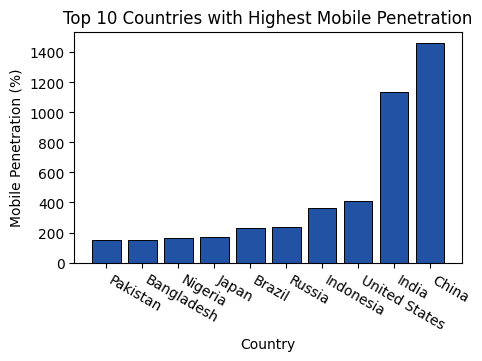

In [32]:
plt.clf()
plt.figure(figsize=(5, 3))
mobile_bar = mobile_ten_data.sort_values(by='Mobile Top 10', ascending=True)
ax = plt.bar(mobile_bar['Top Mobile Country'], mobile_bar['Mobile Top 10'], 
             color='#2252a3', alpha=1, linewidth=0.7, edgecolor="black")

# Add labels and title
plt.xlabel('Country')
plt.xticks(rotation=330, ha='left')
plt.ylabel('Mobile Penetration (%)')
plt.title('Top 10 Countries with Highest Mobile Penetration')

# Show the plot
plt.show()
#plt.savefig("Images/mobile10.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

## Top 10 Countries 2g, 3g, and 4g Coverage

In [ ]:
#Set the Id's for the search
g_ids = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 'Bangladesh', 'Pakistan']

#Search the DataFrame and return the results from the appended list
mobile_coverage = internet_summary[internet_summary['Country'].isin(g_ids)][['Country','2G Coverage', '3G Coverage', '4G Coverage']]

#Set the new order of the DataFrame
order = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 'Bangladesh', 'Pakistan']
coverage_reordered = mobile_coverage.set_index('Country').reindex(order).reset_index()

#Export to CSV
coverage_reordered.to_csv("Resources/Coverage.csv")

#Show
coverage_reordered

In [34]:
#Import the complete CSV
data_to_load = Path("Resources/Coverage.csv")

coverage_data = pd.read_csv(data_to_load)

unwanted_column = ['Unnamed: 0']
coverage_data.drop(columns=unwanted_column, inplace=True)
coverage_data.rename(columns={'2G Coverage': '2G', '3G Coverage': '3G', '4G Coverage': '4G'}, inplace=True)

#Show
coverage_data

,Country,2G,3G,4G
0,China,99.66,98.06,95.86
1,India,96.81,86.76,71.48
2,United States,99.90,99.90,99.76
3,Indonesia,94.36,84.81,62.64
4,Russia,91.98,78.14,65.74
5,Brazil,94.40,94.17,80.46
6,Japan,99.90,99.90,99.00
7,Nigeria,92.33,59.54,17.21
8,Bangladesh,99.51,89.16,71.60
9,Pakistan,87.70,70.92,49.47


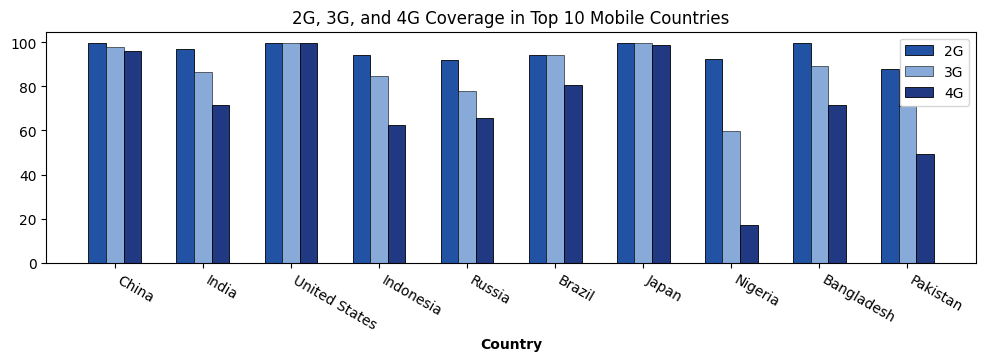

In [35]:
coverage = pd.DataFrame(coverage_data)
plt.figure(figsize=(12, 3))

# Set up positions for bars on x-axis
bar_width = 0.2

space_between_groups = .0
twog = np.arange(len(coverage))
threeg = [x + bar_width + space_between_groups for x in twog]
fourg = [x + bar_width + space_between_groups for x in threeg]

# Create grouped bar chart
plt.bar(twog, coverage['2G'], width=bar_width, color='#2252A3', linewidth=0.6, edgecolor="Black", label='2G')
plt.bar(threeg, coverage['3G'], width=bar_width, color='#88aad9', linewidth=0.4, edgecolor="Black", label='3G')
plt.bar(fourg, coverage['4G'], width=bar_width, color='#213982', linewidth=0.6, edgecolor="Black", label='4G')

# Customize the plot
plt.xlabel('Country', fontweight='bold')
plt.xticks([r + bar_width + space_between_groups for r in range(len(coverage))], coverage['Country'])
plt.xticks(rotation=330, ha='left')
plt.title('2G, 3G, and 4G Coverage in Top 10 Mobile Countries')
plt.legend()
plt.tick_params(axis='both')

# Show the plot
plt.show()
#plt.savefig("Images/'coverage.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

### Top 10 Countries Cost of Broadband v. Cost of Mobile

In [ ]:
#Set the Id's for the search
g_ids = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 'Bangladesh', 'Pakistan']

#Search the DataFrame and return the results from the appended list
cost_analysis = internet_summary[internet_summary['Country'].isin(g_ids)][['Country', 'Broadband Cost (% of GNI)', 'Mobile Cost (% of GNI)']]

#Set the new order of the DataFrame
order = ['China', 'India', 'United States', 'Indonesia', 'Russia', 'Brazil', 'Japan', 'Nigeria', 'Bangladesh', 'Pakistan']
cost_reordered = cost_analysis.set_index('Country').reindex(order).reset_index()

#Show
cost_reordered.to_csv("Resources/Cost_comparisons.csv")

#Show
cost_reordered

In [36]:
#Import the complete CSV
data_to_load = Path("Resources/Cost_comparisons.csv")

cost_data = pd.read_csv(data_to_load)

unwanted_column = ['Unnamed: 0']
cost_data.drop(columns=unwanted_column, inplace=True)
cost_data.rename(columns={'Broadband Cost (% of GNI)': 'Broadband Cost', 
                          'Mobile Cost (% of GNI)': 'Mobile Cost'}, inplace=True)

#Show
cost_data

,Country,Broadband Cost,Mobile Cost
0,China,2.34,0.85
1,India,4.60,2.18
2,United States,0.84,0.15
3,Indonesia,8.94,0.85
4,Russia,0.55,0.24
5,Brazil,2.09,2.18
6,Japan,0.83,1.74
7,Nigeria,14.61,2.43
8,Bangladesh,3.67,3.22
9,Pakistan,5.94,3.32


<Figure size 640x480 with 0 Axes>

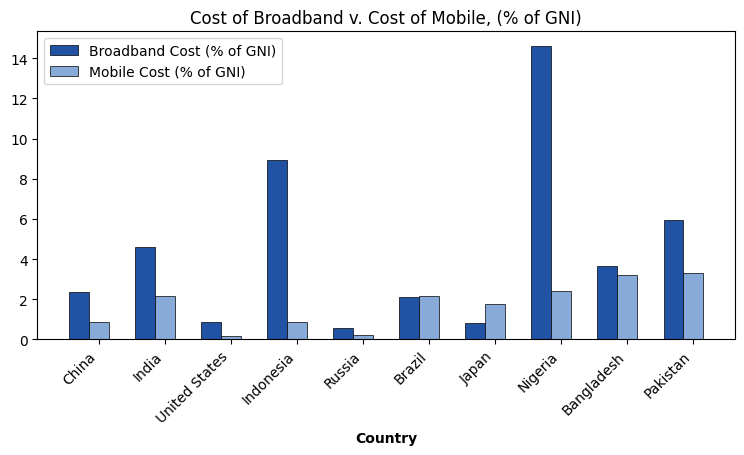

In [38]:
cost = pd.DataFrame(cost_data)
plt.figure(figsize=(9, 4))

# Set up positions for bars on x-axis
bar_width = 0.3

space_between_groups = 0.0
broadband = np.arange(len(cost))
mobile = [x + bar_width + space_between_groups for x in broadband]

# Create grouped bar chart
plt.bar(broadband, cost['Broadband Cost'], width=bar_width, color='#2252A3', 
        linewidth=0.5, edgecolor="black", label='Broadband Cost (% of GNI)')
plt.bar(mobile, cost['Mobile Cost'], width=bar_width, color='#88aad9', 
        linewidth=0.5, edgecolor="black", label='Mobile Cost (% of GNI)')

# Customize the plot
plt.xlabel('Country', fontweight='bold')
plt.xticks([r + bar_width + space_between_groups for r in range(len(coverage))], coverage['Country'])
plt.xticks(rotation=45, ha='right')
plt.title('Cost of Broadband v. Cost of Mobile, (% of GNI)')
plt.legend()

# Show the plot
plt.show()
#plt.savefig("Images/'broadband_mobile_cost.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)